In [1]:
# imports 
import os 
import pandas as pd 
import sklearn 
import tensorflow as tf 
import numpy as np 
import shutil
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
from PIL import Image
import glob
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import cv2
from skimage.feature import graycomatrix, graycoprops, hog
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, History
from keras.utils import plot_model
import graphviz
from keras import Input
from keras.regularizers import l2

os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

In [3]:
def glcm_extraction(images): 
    image_data = pd.DataFrame()
    for image in images: 
        df = pd.DataFrame()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        distance = [[1], [3], [5], [3], [3], [7]]
        angles = [[0], [0], [0], [np.pi/4], [np.pi/2]]

        for n, (dist, angle) in enumerate(zip(distance, angles)): 
            glcm = graycomatrix(image, dist, angle)
            glcm_e = graycoprops(glcm, 'energy')[0]
            df['Energy'+str(n)] = glcm_e
            glcm_corr = graycoprops(glcm, 'correlation')[0]
            df['Corr'+str(n)] = glcm_corr       
            glcm_diss = graycoprops(glcm, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = glcm_diss       
            glcm_homm = graycoprops(glcm, 'homogeneity')[0]
            df['Homogen'+str(n)] = glcm_homm       
            glcm_contr = graycoprops(glcm, 'contrast')[0]
            df['Contrast'+str(n)] = glcm_contr
        
        image_data = pd.concat([image_data, df], ignore_index=True)

    return image_data 

def hog_extraction(images):
    features = []
    count = 0
    for image in images: 
        image = cv2.resize(image, (128, 64))
        feature_array = hog(image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True, channel_axis=2)
        features.append(feature_array)
        
        
        hog_data = pd.DataFrame(features)
        count+=1
    print('HOG finished')
    
    return hog_data          

In [5]:
train_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
test_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/test"

# np array images 
categories_dict = {
  "benign": 0,
  "malignant": 1
}


SIZE = 140
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 50
STEP_SIZE = 28

In [6]:
train_images = []
train_labels = [] 
train_labels_cat = []
images = []

for directory in os.listdir(train_dir): 
    label = categories_dict[directory]
    label_cat = directory
    for img_path in glob.glob(os.path.join(train_dir+"/"+str(directory), "*.jpg")): 
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
        train_labels.append(label)
        train_labels_cat.append(label_cat)
print(len(train_images))
print(len(train_labels))

2637
2637


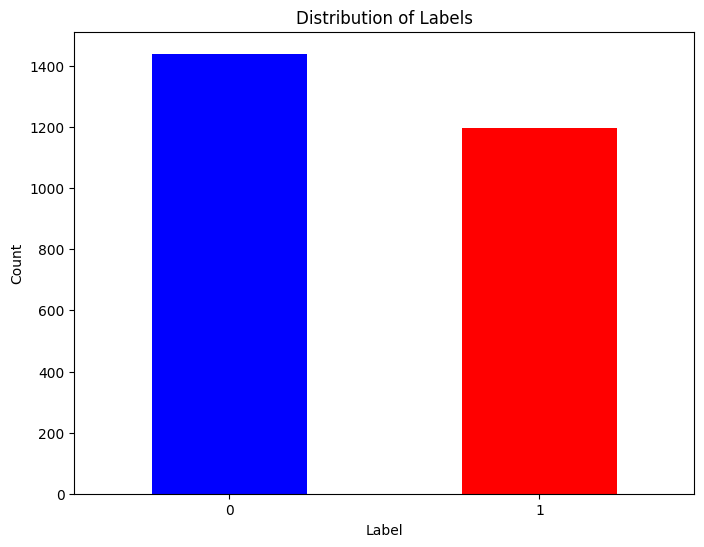

In [6]:
df = pd.DataFrame(train_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
test_images = []
test_labels = [] 
test_labels_cat = []
test_labels_test = []
images = []

for directory in os.listdir(test_dir): 
    label = categories_dict[directory]
    label_cat = directory
    for img_path in glob.glob(os.path.join(test_dir+"/"+str(directory), "*.jpg")): 
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_images.append(img)
        test_labels.append(label)
        test_labels_test.append(label)
        test_labels_cat.append(label)
print(len(test_images))
print(len(test_labels))
test_images = np.array(test_images)

660
660


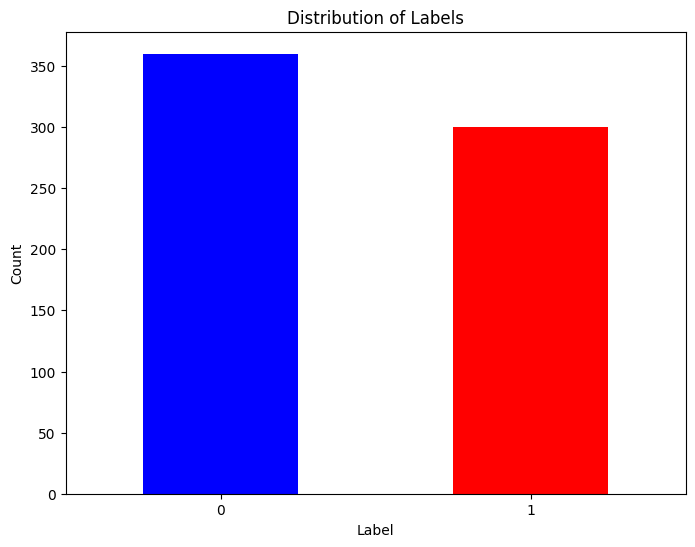

In [8]:
df = pd.DataFrame(test_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [8]:
x_train = np.array(train_images)
x_train_labels = np.array(train_labels)
combined_train = list(zip(x_train, x_train_labels))

np.random.shuffle(combined_train)

# Separate them back into images and labels
shuffled_images, shuffled_labels = zip(*combined_train)

# Convert them back to numpy arrays if needed
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)

In [9]:
train_images, val_images, train_labels, val_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.2, random_state=100)

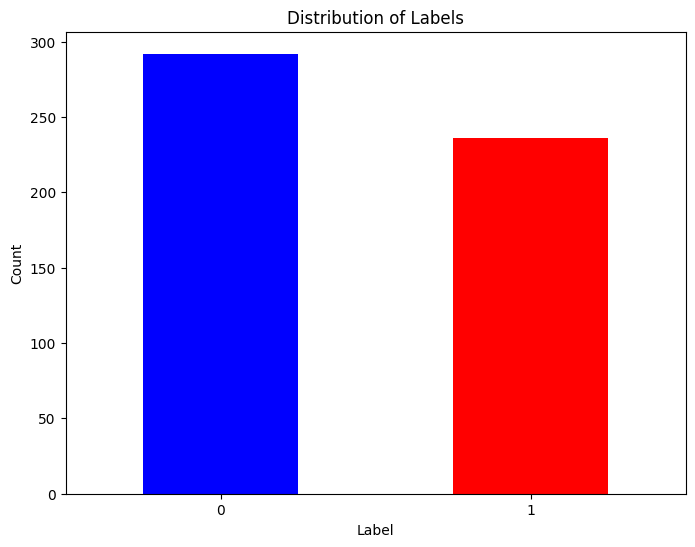

In [13]:
df = pd.DataFrame(val_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [10]:
print("train:",train_images.shape[0])
print("val:", val_images.shape[0])
print("test:", test_images.shape[0])

train: 2109
val: 528
test: 660


In [11]:
train_features = glcm_extraction(train_images)
test_features = glcm_extraction(test_images)
val_features = glcm_extraction(val_images)

In [12]:
val_hog = hog_extraction(val_images)

Validation Done


In [13]:
test_hog = hog_extraction(test_images)

Validation Done
Test Done


In [14]:
train_hog = hog_extraction(train_images)

Validation Done
Test Done
Train Done


In [15]:
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [16]:
pd.set_option("display.max_columns", None)
train_features.head()

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.036384,0.970408,4.784327,0.226658,64.747122,0.030157,0.894423,8.788008,0.150236,227.491032,0.028403,0.802567,11.674074,0.126929,421.917354,0.030152,0.912699,8.157372,0.151247,188.902699,0.030204,0.918475,7.882690,0.155123,178.678206
1,0.026466,0.967677,5.081706,0.209909,62.608736,0.019280,0.869124,10.466997,0.106432,255.219447,0.017886,0.796708,13.266349,0.086386,399.307619,0.019827,0.859119,10.078240,0.114195,275.297206,0.020422,0.873059,9.455892,0.120193,247.134619
2,0.059715,0.929547,3.069013,0.328110,36.281860,0.047591,0.763857,5.309333,0.217995,114.578571,0.044125,0.615003,6.667407,0.182752,178.036190,0.048351,0.740369,5.457362,0.225225,126.536967,0.050041,0.812723,4.969395,0.243122,96.331648
3,0.046925,0.982266,2.556115,0.327497,11.976978,0.036506,0.941977,4.595673,0.210851,39.601512,0.033371,0.900963,5.913545,0.171460,68.350265,0.036804,0.943615,4.523997,0.213330,38.369198,0.037225,0.946964,4.414442,0.220032,36.123410
4,0.018376,0.978522,6.793988,0.146242,82.972199,0.014738,0.927552,12.612878,0.084677,281.908394,0.013801,0.870468,16.586349,0.068672,507.029524,0.015063,0.934966,11.978838,0.088760,253.352604,0.015283,0.939716,11.546350,0.089681,233.578467


In [17]:
train_hog.head()

0         1         2         3         4         5         6     \
0  0.245425  0.130475  0.245425  0.133261  0.245425  0.031928  0.017315   
1  0.165500  0.077448  0.240536  0.059299  0.230775  0.053316  0.082556   
2  0.353259  0.509886  0.509886  0.014299  0.075329  0.029955  0.010243   
3  0.201367  0.134181  0.076079  0.192551  0.238232  0.164384  0.175029   
4  0.141938  0.193820  0.177862  0.146711  0.222550  0.098300  0.073937   

       7         8         9         10        11        12        13    \
0  0.088725  0.141045  0.215338  0.062073  0.105390  0.079269  0.245425   
1  0.044151  0.052914  0.191578  0.153831  0.254729  0.254729  0.254729   
2  0.016196  0.008812  0.187609  0.082419  0.077923  0.015602  0.101876   
3  0.096803  0.018400  0.238232  0.172325  0.162944  0.227799  0.116028   
4  0.090816  0.043951  0.197811  0.145138  0.243380  0.222203  0.111097   

       14        15        16        17        18        19        20    \
0  0.245425  0.210337  0.096572  0.000000  0.135203  0.142870  0.192526   
1  0.073832  0.097663  0.117727  0.114482  0.026361  0.111838  0.064800   
2  0.045447  0.014544  0.079545  0.016519  0.157471  0.240792  0.075537   
3  0.229752  0.162185  0.084430  0.122757  0.078412  0.238232  0.209082   
4  0.101371  0.153721  0.093075  0.028283  0.106586  0.175833  0.243380   

       21        22        23        24        25        26        27    \
0  0.245425  0.245425  0.110969  0.046700  0.166893  0.186033  0.104521   
1  0.120033  0.254729  0.235949  0.140415  0.093003  0.038011  0.097851   
2  0.091980  0.383991  0.027256  0.030933  0.050118  0.027942  0.058351   
3  0.146352  0.238232  0.140248  0.025244  0.050077  0.036800  0.071951   
4  0.231005  0.237895  0.181541  0.149791  0.175661  0.066275  0.243380   

       28        29        30        31        32        33        34    \
0  0.205944  0.245425  0.245425  0.146059  0.186744  0.036974  0.082179   
1  0.065428  0.254729  0.254729  0.254729  0.254729  0.222755  0.104488   
2  0.060813  0.127010  0.043880  0.040905  0.047397  0.008195  0.035795   
3  0.238232  0.177961  0.238232  0.224412  0.120913  0.238232  0.101021   
4  0.215751  0.243380  0.243380  0.064246  0.120506  0.060397  0.133691   

       35        36        37        38        39        40        41    \
0  0.049699  0.213120  0.061433  0.104304  0.078453  0.231823  0.231823   
1  0.156435  0.160142  0.128590  0.235165  0.245604  0.232637  0.061717   
2  0.025360  0.243222  0.233596  0.220853  0.044221  0.243222  0.128808   
3  0.059657  0.236666  0.159963  0.151255  0.211458  0.107705  0.213271   
4  0.152457  0.210984  0.154804  0.250902  0.237000  0.118496  0.108121   

       42        43        44        45        46        47        48    \
0  0.208170  0.095577  0.000000  0.231823  0.100206  0.178786  0.190983   
1  0.081638  0.098410  0.095697  0.147306  0.077014  0.209189  0.245604   
2  0.041220  0.225450  0.046819  0.243222  0.180435  0.213705  0.125035   
3  0.150551  0.078373  0.113951  0.236666  0.224797  0.194811  0.236666   
4  0.163958  0.099274  0.030166  0.250902  0.159008  0.250902  0.168572   

       49        50        51        52        53        54        55    \
0  0.210505  0.197809  0.046631  0.147900  0.077598  0.103444  0.203822   
1  0.245604  0.101315  0.104356  0.053170  0.035511  0.081795  0.054692   
2  0.169069  0.226984  0.005806  0.038891  0.042874  0.165380  0.172360   
3  0.229454  0.130393  0.168751  0.066923  0.047238  0.066790  0.236666   
4  0.102677  0.092230  0.130230  0.047244  0.145011  0.250902  0.230119   

       56        57        58        59        60        61        62    \
0  0.231823  0.231823  0.144554  0.184819  0.036593  0.081332  0.049187   
1  0.245604  0.245604  0.245604  0.245604  0.186204  0.087343  0.130766   
2  0.243222  0.124368  0.115933  0.134336  0.023226  0.101451  0.071877   
3  0.165194  0.236666  0.208314  0.112239  0.236666  0.093774  0.055377   
4  0.250902  0.250902  0

In [18]:
train_hog.shape

(2109, 3780)

In [26]:
def create_combined_model(learning_rate=float(0.0001)): 
    feautres = Input(shape=(3805,))
    x1 = keras.layers.Dense(128, activation='relu')(feautres)
    x1 = keras.layers.Dense(64, activation='relu')(x1)
    x1 = keras.layers.Dense(32, activation='relu')(x1)
    x1 = keras.layers.Dense(16, activation='relu')(x1)

    cnn_input = Input((140,140,3))
    x2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu')(cnn_input)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Flatten()(x2)
    
    combined = keras.layers.Concatenate()([x1,x2])

    x = keras.layers.Dense(16, activation='relu')(combined)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(8, activation='relu')(x)
    x = keras.layers.Dense(4, activation='relu')(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model([feautres, cnn_input], x)

    print(model.summary())

    aopt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=aopt, loss=keras.losses.BinaryCrossentropy(), 
                    metrics=[keras.metrics.BinaryAccuracy()])
    
    return model

In [27]:
model = create_combined_model()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 140, 140,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 138, 138,  │      7,168 │ input_layer_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 138, 138,  │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 69, 69,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 69, 69,    │          0 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 67, 67,    │    295,040 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 67, 67,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 33, 33,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 33, 33,    │          0 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 3805)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 31, 31,    │     73,792 │ dropout_9[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │    487,168 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 15, 15,    │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        528 │ dense_18[0][0]  

 Total params: 1,106,737 (4.22 MB)

 Trainable params: 1,105,809 (4.22 MB)

 Non-trainable params: 928 (3.62 KB)

None


In [28]:
callb = [
    ModelCheckpoint(
        'glcm_cnn_model_best.keras', 
        monitor='val_binary_accuracy', 
        verbose=1, 
        save_best_only=True, 
        mode='max'),
        ]

In [ ]:
data_inputs = tf.data.Dataset.from_tensor_slices((train_features, tf.expand_dims(train_images_norm, axis=-1)))
data_labels = tf.data.Dataset.from_tensor_slices(train_labels)

val_inputs = tf.data.Dataset.from_tensor_slices((val_features, tf.expand_dims(val_images_norm, axis=-1)))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

val_dataset = tf.data.Dataset.zip((val_inputs, val_labels)).batch(BATCH_SIZE).repeat()

dataset = tf.data.Dataset.zip((data_inputs, data_labels)).batch(BATCH_SIZE).repeat()


In [24]:
# same code as above but including HOG features 

combined_train_features = tf.concat([train_features, train_hog], axis=1)
combined_val_features = tf.concat([val_features, val_hog], axis=1)

data_inputs = tf.data.Dataset.from_tensor_slices((combined_train_features, tf.expand_dims(train_images_norm, axis=-1)))
data_labels = tf.data.Dataset.from_tensor_slices(train_labels)

val_inputs = tf.data.Dataset.from_tensor_slices((combined_val_features, tf.expand_dims(val_images_norm, axis=-1)))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

val_dataset = tf.data.Dataset.zip((val_inputs, val_labels)).batch(BATCH_SIZE).repeat()

dataset = tf.data.Dataset.zip((data_inputs, data_labels)).batch(BATCH_SIZE).repeat()

In [29]:
history_v1 = model.fit(dataset, validation_data=val_dataset, validation_steps=(len(val_features) // BATCH_SIZE) ,epochs=EPOCH_NUM, steps_per_epoch=STEP_SIZE, callbacks=callb)

Epoch 1/50


I0000 00:00:1725917045.060839     170 service.cc:145] XLA service 0x7b85c009a050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725917045.060887     170 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/28 ━━━━━━━━━━━━━━━━━━━━ 8:37 19s/step - binary_accuracy: 0.4844 - loss: 0.7432

I0000 00:00:1725917060.296047     170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - binary_accuracy: 0.5207 - loss: 0.6977
Epoch 1: val_binary_accuracy improved from -inf to 0.70703, saving model to glcm_cnn_model_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - binary_accuracy: 0.5224 - loss: 0.6970 - val_binary_accuracy: 0.7070 - val_loss: 0.6810
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - binary_accuracy: 0.6263 - loss: 0.6451
Epoch 2: val_binary_accuracy did not improve from 0.70703
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 649ms/step - binary_accuracy: 0.6266 - loss: 0.6450 - val_binary_accuracy: 0.6379 - val_loss: 0.6588
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - binary_accuracy: 0.6824 - loss: 0.6154
Epoch 3: val_binary_accuracy did not improve from 0.70703
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - binary_accuracy: 0.6818 - loss: 0.6155 - val_binary_accuracy: 0.6336 - val_loss: 0.6485
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - binary_accuracy: 0.7139 - loss: 0.5924
Epoch 4: val_binary_accuracy 

In [ ]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

In [30]:
# with hog features 

combined_test_features = tf.concat([test_features, test_hog], axis=1)

test_inputs = tf.data.Dataset.from_tensor_slices((combined_test_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

In [31]:
score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test binary accuracy: {score[1]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5661 - loss: 0.8449
Test loss: 0.6209729909896851 / Test binary accuracy: 0.6937500238418579


In [32]:
history_v1.history.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

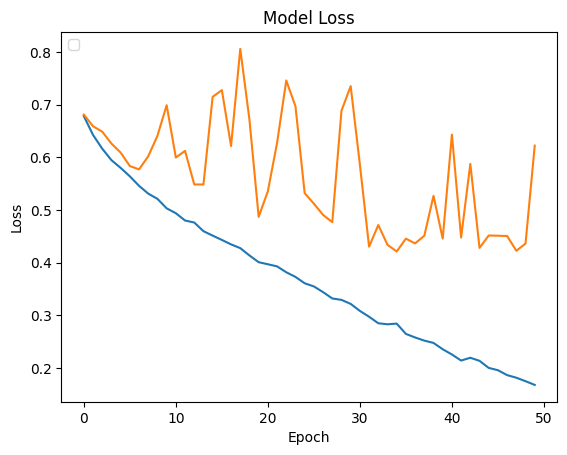

In [33]:
plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

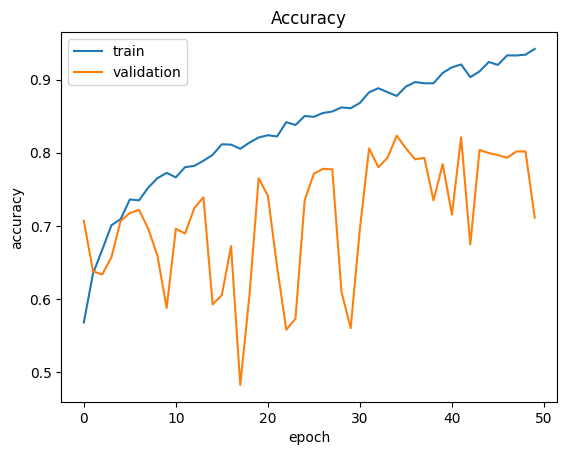

In [34]:
plt.plot(history_v1.history['binary_accuracy'])
plt.plot(history_v1.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
preds = model.predict(test_dataset, steps=STEP_SIZE_TEST, batch_size=BATCH_SIZE)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


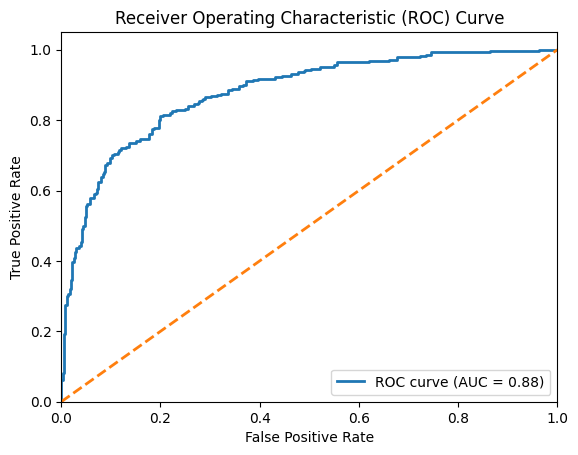

In [36]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_labels_test[:640], preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [1]:
rounded_array = np.where(preds >= 0.37, 1, 0)

NameError: name 'np' is not defined

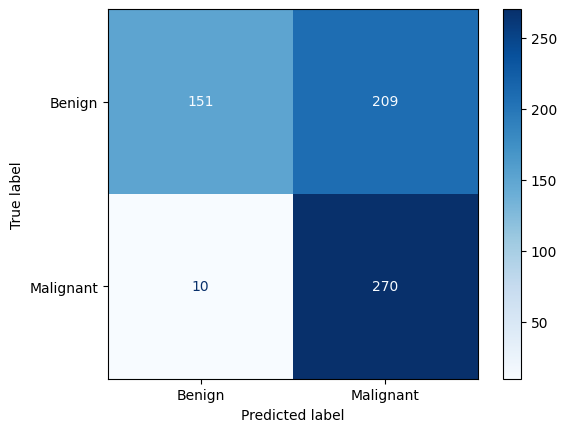

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels_test[:640], rounded_array, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap=plt.cm.Blues, values_format='d')